#### Importing Libraries

In [115]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import joblib
from yellowbrick.cluster import KElbowVisualizer
import json
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [116]:
# Function used to fill NaN values within the dataframe X
def fill_NaN(X):
  for col in X:
    X.loc[:, col] = X.loc[:, col].fillna(1)
  return X

In [117]:
# Elbow method plot
def plot_elbow(K, distortions):
    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distorsione')
    plt.title('Il Metodo del Gomito')
    plt.show()

#### Retrieving dataset

In [118]:
PATH_TO_CSV = 'output/generator'
FUNCTION_NAMES = ['figlet', 'shasum', 'nmap', 'env', 'curl', 'eat-memory']
FUNCTION_NAMES_REDUCED = ['figlet', 'shasum', 'nmap', 'env', 'curl']
COLUMNS_NAMES = ['name', 'rate', 'success_rate', 'cpu_usage', 'ram_usage', 'power', 'overloaded', 'medium_latency']
COLUMNS_REDUCED = ['rate', 'success_rate', 'cpu_usage', 'ram_usage', 'power', 'overloaded', 'medium_latency']
COLUMNS_SCALED = ['rate', 'success_rate', 'cpu_usage', 'ram_usage', 'power', 'medium_latency']

FUNCTIONS_TO_SKIP = ['env']

# Retrieve all files in the output folder
file_csv = [file for file in os.listdir(PATH_TO_CSV) if file.endswith('.csv')]
file_csv.sort()

#### Get all data from files

In [122]:
# Initialize an empty DataFrame
df = pd.DataFrame()

for file in file_csv:
    file_path = os.path.join(PATH_TO_CSV, file)
    # Read CSV file
    df_file = pd.read_csv(file_path)
    # Add the current DataFrame to the main DataFrame
    df = pd.concat([df, df_file], ignore_index=True)

# Drop functions to skip (if any)
df = df[~df['name'].isin(FUNCTIONS_TO_SKIP)].reset_index(drop = True)

# Delete 'name' column
df_no_name = df.drop(columns='name', errors='ignore')

df['name'].unique()

array(['curl', 'nmap', 'eat-memory', 'figlet', 'shasum'], dtype=object)

##### Preprocessing

In [123]:
scaler = MinMaxScaler()

# Apply MinMax scaling to the DataFrame
scaling_model = scaler.fit(df_no_name)
joblib.dump(scaling_model, 'scaling_model.joblib')
df_no_name_scaled = scaling_model.transform(df_no_name)

# Create a scaled DataFrame with the same columns
df_one_function_scaled = pd.DataFrame(df_no_name_scaled, columns=df_no_name.columns)

df_one_function_scaled['name'] = df['name']
df_one_function_scaled['name'].unique()

array(['curl', 'nmap', 'eat-memory', 'figlet', 'shasum'], dtype=object)

##### Function to create plots

In [124]:
def print_line_plots(df):
    for col in df.columns:
        if col not in ['rate', 'name']:  
            plt.figure(figsize=(10, 6))  
            for name in FUNCTION_NAMES:
                temp_df = df[df['name'] == name].copy()  
                if col == 'medium_latency':
                    temp_df[col] = temp_df[col] / 1e9  
                if col == 'ram_usage':
                    temp_df[col] = temp_df[col] / 1e6  
                if col == 'success_rate':
                    temp_df[col] = temp_df[col] * 100  
                plt.plot(temp_df['rate'], temp_df[col], label=name, marker='o', linestyle='-')
            
            unit = {
                'success_rate': '%',  
                'cpu_usage': '%',
                'ram_usage': 'MB',  
                'power_usage': 'μW',
                'overloaded': '',  
                'medium_latency': 's'  
            }[col]

            plt.title(f'{col.capitalize()} per differenti funzioni')
            plt.xlabel('Rate (req/s)')
            plt.ylabel(f'{col.capitalize()} ({unit})')
            
            if col == 'overloaded':
                plt.yticks([0, 1])

            plt.legend()
            plt.grid(True)
            plt.show()


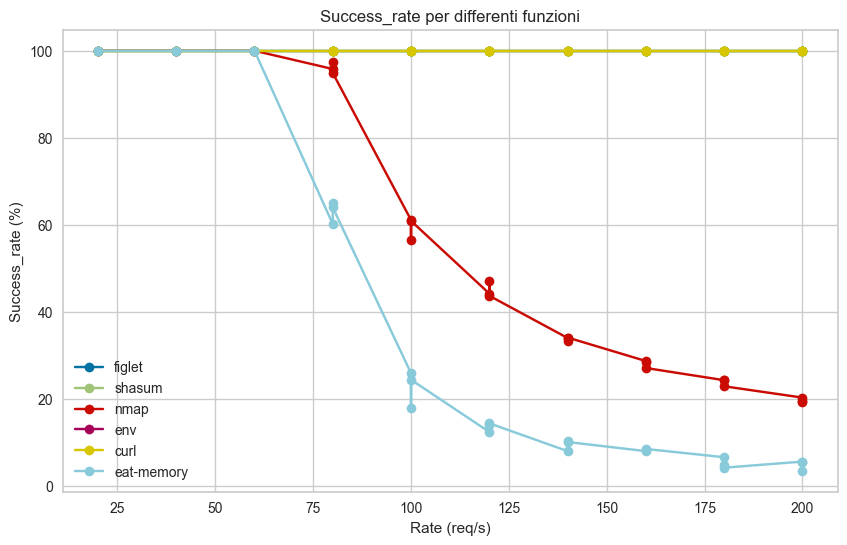

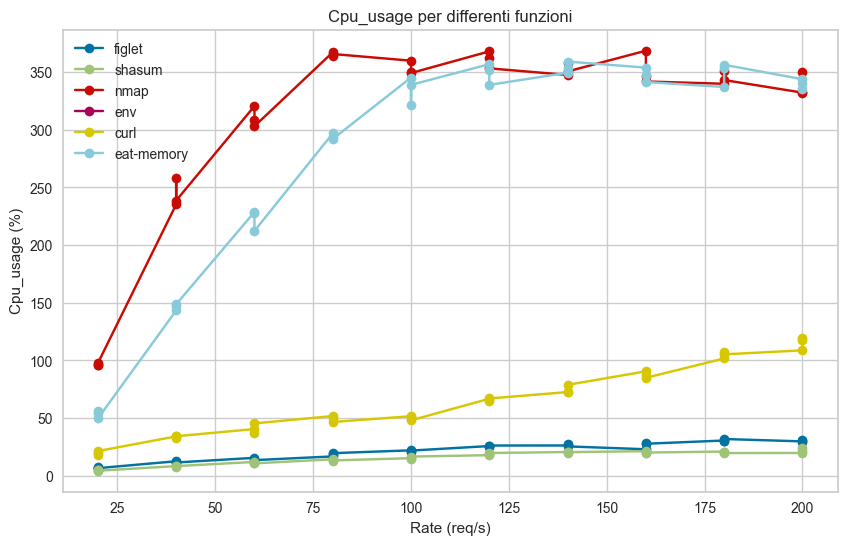

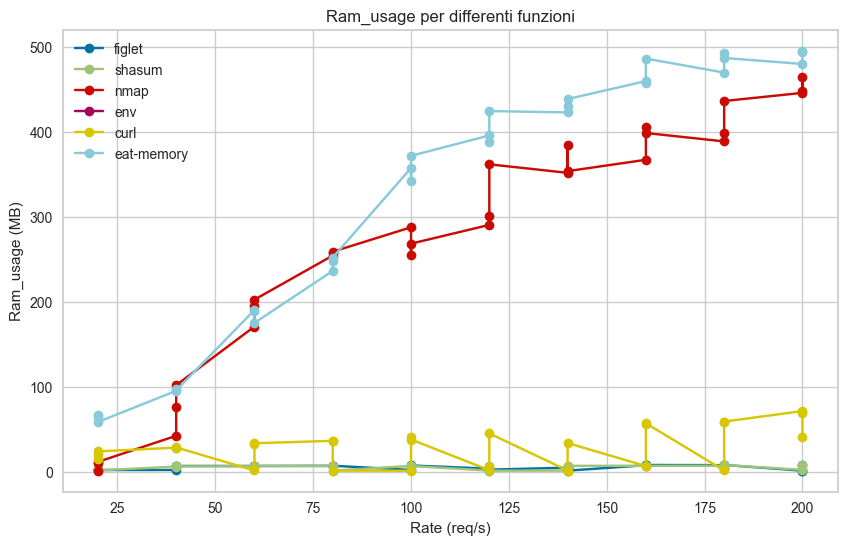

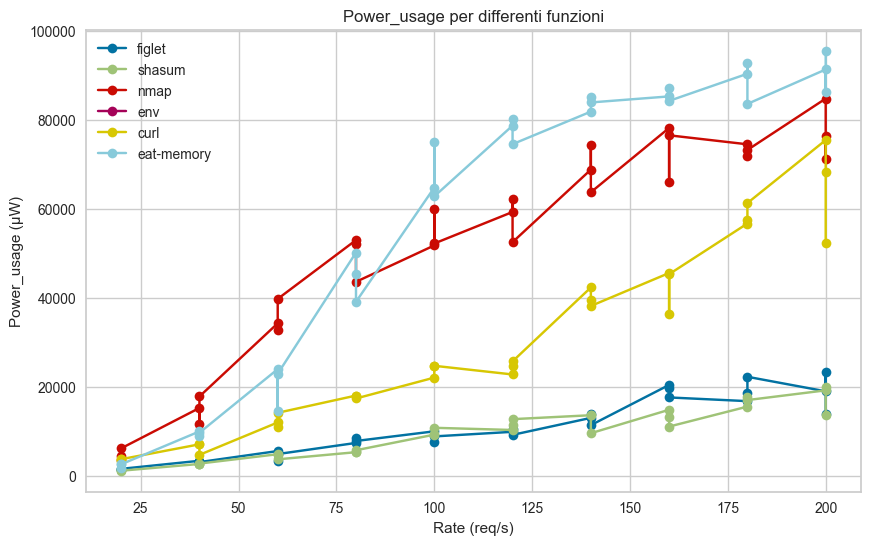

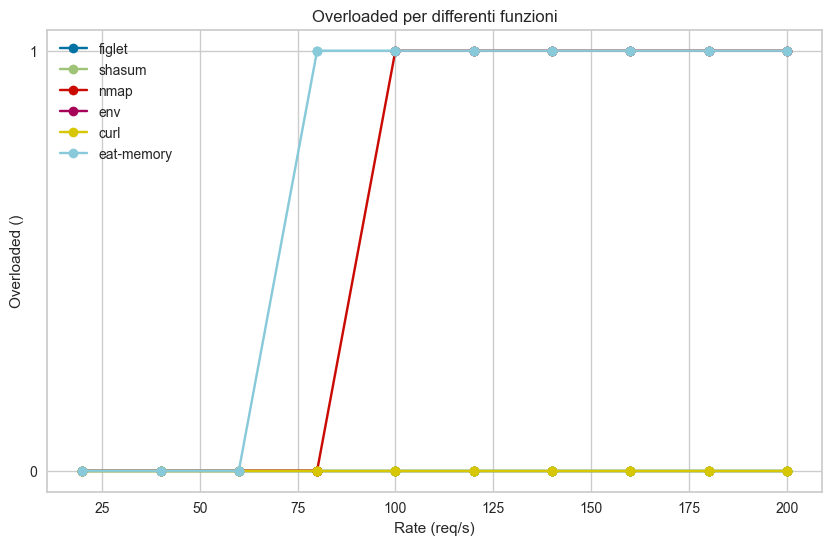

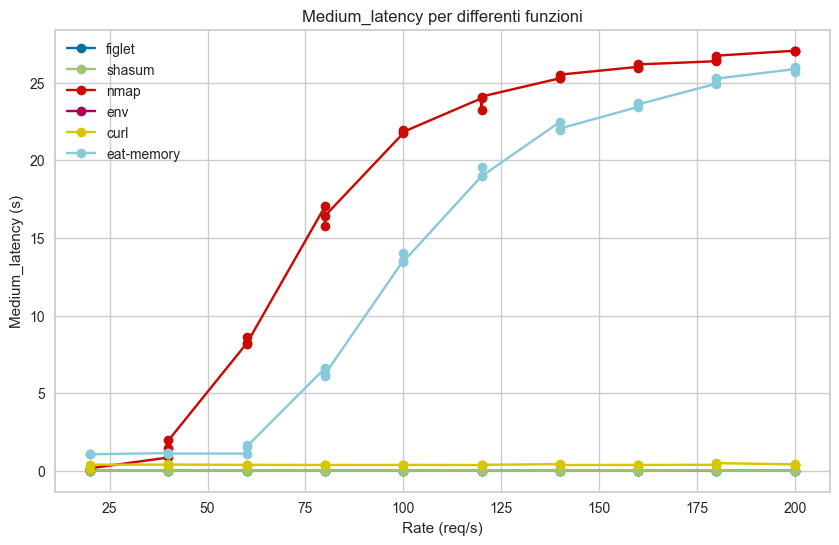

In [125]:
print_line_plots(df)

#### Create vectors

In [126]:
# Split the DataFrame according to the column "name"
data_per_function = {}
for name, group in df_one_function_scaled.groupby('name'):
    data_per_function[name] = group

# Loop through each function's DataFrame in the dictionary
for function_name, function_data in data_per_function.items():

    # Remove the "name" column from each DataFrame in the dictionary
    function_data = function_data.drop(columns=['name'])
    
    # Add the prefix "avg_" to each column
    function_data.columns = 'avg_' + function_data.columns

    # Calculate the average of the values for each group with the same 'rate'
    compressed_data = function_data.groupby('avg_rate').mean().reset_index()

    # Calculate the maximum values for each group of three rows
    max_data = function_data.groupby('avg_rate').max().reset_index()

    # Calculate the minimum values for each group of three rows
    min_data = function_data.groupby('avg_rate').min().reset_index()

    # Add the "max_" columns to the compressed DataFrame
    compressed_data['max_success_rate'] = max_data['avg_success_rate']
    compressed_data['max_cpu_usage'] = max_data['avg_cpu_usage']
    compressed_data['max_ram_usage'] = max_data['avg_ram_usage']
    compressed_data['max_power'] = max_data['avg_power_usage']
    compressed_data['max_overloaded'] = max_data['avg_overloaded']
    compressed_data['max_medium_latency'] = max_data['avg_medium_latency']

    # Add the "min_" columns to the compressed DataFrame
    compressed_data['min_success_rate'] = min_data['avg_success_rate']
    compressed_data['min_cpu_usage'] = min_data['avg_cpu_usage']
    compressed_data['min_ram_usage'] = min_data['avg_ram_usage']
    compressed_data['min_power'] = min_data['avg_power_usage']
    compressed_data['min_overloaded'] = min_data['avg_overloaded']
    compressed_data['min_medium_latency'] = min_data['avg_medium_latency']

    compressed_data = compressed_data.drop(columns='avg_rate')

    data_per_function[function_name] = compressed_data

# Show example
data_per_function["curl"]

,avg_success_rate,avg_cpu_usage,avg_ram_usage,avg_power_usage,avg_overloaded,avg_medium_latency,max_success_rate,max_cpu_usage,max_ram_usage,max_power,max_overloaded,max_medium_latency,min_success_rate,min_cpu_usage,min_ram_usage,min_power,min_overloaded,min_medium_latency
0,1.0,0.042819,0.038106,0.025606,0.0,0.007393,1.0,0.046811,0.045965,0.027411,0.0,0.014492,1.0,0.038471,0.028439,0.022472,0.0,0.003687
1,1.0,0.080943,0.054961,0.054647,0.0,0.014685,1.0,0.082114,0.055526,0.063305,0.0,0.014818,1.0,0.078934,0.054368,0.037780,0.0,0.014529
2,1.0,0.100464,0.043256,0.118612,0.0,0.013843,1.0,0.112735,0.065356,0.137921,0.0,0.013982,1.0,0.089403,0.000556,0.103013,0.0,0.013768
3,1.0,0.123688,0.047680,0.176169,0.0,0.013725,1.0,0.130205,0.071495,0.178957,0.0,0.013743,1.0,0.116101,0.000294,0.171969,0.0,0.013715
4,1.0,0.126223,0.051236,0.240059,0.0,0.013824,1.0,0.129762,0.079429,0.249824,0.0,0.013929,1.0,0.119997,0.000000,0.221717,0.0,0.013749
5,1.0,0.169700,0.033127,0.246226,0.0,0.013694,1.0,0.172022,0.088851,0.260423,0.0,0.014119,1.0,0.165669,0.001271,0.229184,0.0,0.013473
6,1.0,0.193152,0.022259,0.411899,0.0,0.014274,1.0,0.204471,0.065943,0.436254,0.0,0.015590,1.0,0.187304,0.000325,0.392263,0.0,0.013571
7,1.0,0.228882,0.078266,0.437490,0.0,0.013778,1.0,0.236649,0.112897,0.470766,0.0,0.013828,1.0,0.221200,0.011101,0.373732,0.0,0.013729
8,1.0,0.275711,0.077766,0.607240,0.0,0.015366,1.0,0.282722,0.116944,0.637283,0.0,0.018183,1.0,0.267281,0.000543,0.588587,0.0,0.013905
9,1.0,0.304681,0.120118,0.680459,0.0,0.014413,1.0,0.315537,0.142105,0.787236,0.0,0.015077,1.0,0.286574,0.080035,0.543248,0.0,0.014049


In [127]:
# Create one DataFrame for each function

# Initialize a dictionary to store vectors for each functions
vectors_per_function = {}

# Loop through each DataFrame function in the dictionary
for function_name, function_data in data_per_function.items():
    # Concatenates all rows in the DataFrame into a vector
    vector = function_data.to_numpy().flatten()
    # Saves the vector in the dictionary with the function name as the key
    vectors_per_function[function_name] = vector

# Trasform Numpy Array to DataFrame pandas

# Initialize a dictionary to store DataFrames for each function
dataframes_per_function = {}

# Loop through each vector in the dictionary
for function_name, vector in vectors_per_function.items():
    # Create a DataFrame from the vector
    dataframe = pd.DataFrame(vector)

    # Save the DataFrame in the new dictionary with the function name as the key. Traspose Dataframe
    dataframes_per_function[function_name] = dataframe.T

# Create functions Dataframe

# Create an empty list to store DataFrames
all_dataframes = []
function_order = []
# Loop through the DataFrames in dataframes_per_function and add them to the list
for function_name, dataframe in dataframes_per_function.items():
    all_dataframes.append(dataframe)
    function_order.append(function_name)

# Concatenate all DataFrames in the list to create a single one
combined_dataframe = pd.concat(all_dataframes, ignore_index=True)

# Scale

fill_NaN(combined_dataframe)

combined_dataframe

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,1.0,0.042819,0.038106,0.025606,0.0,0.007393,1.0,0.046811,0.045965,0.027411,...,0.142105,0.787236,0.0,0.015077,1.000000,0.286574,0.080035,0.543248,0.0,0.014049
1,1.0,0.134636,0.126045,0.012593,0.0,0.039157,1.0,0.141607,0.133502,0.016242,...,1.000000,1.000000,1.0,0.961045,0.000000,0.908889,0.968445,0.901003,1.0,0.948570
2,1.0,0.006609,0.002431,0.003223,0.0,0.000202,1.0,0.008327,0.004196,0.004457,...,0.014038,0.234409,0.0,0.000214,1.000000,0.069229,0.000131,0.136127,0.0,0.000084
3,1.0,0.252962,0.013471,0.038396,0.0,0.004597,1.0,0.256151,0.021064,0.053293,...,0.936608,0.886052,1.0,1.000000,0.163731,0.900249,0.899683,0.741843,1.0,0.998284
4,1.0,0.000458,0.001356,0.001738,0.0,0.000149,1.0,0.000736,0.003073,0.003006,...,0.013860,0.198223,0.0,0.000049,1.000000,0.042246,0.002102,0.132440,0.0,0.000000


In [128]:
function_order

['curl', 'eat-memory', 'figlet', 'nmap', 'shasum']

In [129]:
combined_dataframe.to_csv("output/combined_dataframe.csv", index = False)
with open("output/functions_order.txt", "w") as ostream:
  for line in function_order:
    ostream.write(line)
    ostream.write('\n')

[9.51945003e-01 3.46347160e-02 1.33395056e-02 8.07754587e-05
 1.19257843e-32]


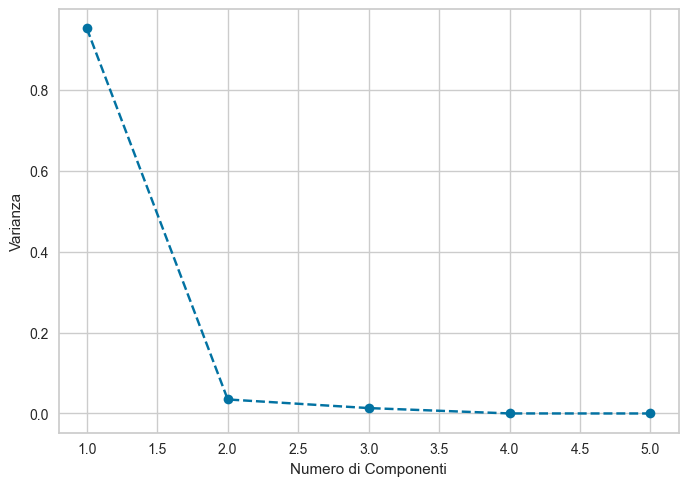

In [130]:
# Calculate cosine distance for all the vectors representing the functions
df_cosine=pd.DataFrame(cosine_similarity(combined_dataframe), columns=function_order)

# Create a PCA model
pca = PCA()

# Apply PCA to the df_functions DataFrame
pca_results = pca.fit_transform(combined_dataframe)

# Number of dimension for PCA
pca_dimensions = len(combined_dataframe.index)

# Create a new DataFrame to store the PCA results
pca_df = pd.DataFrame(data=pca_results, columns=[f'PC{i}' for i in range(1, pca_dimensions + 1)])

# Get the explained variance ratios
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

plt.plot(range(1, pca_dimensions + 1),
             explained_variance, marker='o', linestyle='--')
plt.xlabel('Numero di Componenti')
plt.ylabel('Varianza')
plt.show()

summed_variance = 0
index = 0
while summed_variance <= 0.95:
    summed_variance += explained_variance[index]
    index += 1
after_column = "PC" + str(index)
pca_df = pca_df.truncate(before="PC1", after=after_column, axis="columns")
# Save PCA model
joblib.dump(pca, 'pca_model.joblib')

# Calculate cosine distance for all the pca vectors representing the functions
df_cosine_pca=pd.DataFrame(cosine_similarity(pca_df), columns=function_order)

#### Search the best K params

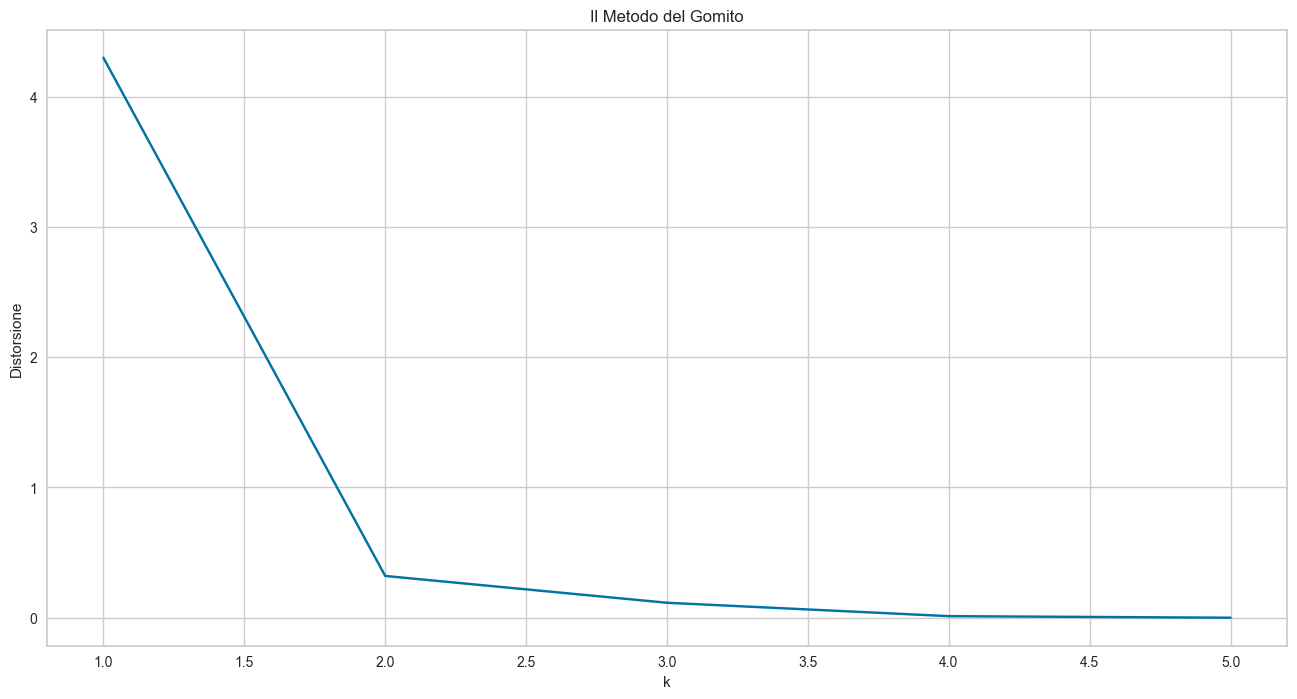

In [131]:
distortions = []
inertias = []
silhouette_scores = {}
K = range(1,6)
for k in K:
    model_kmeans_k = KMeans(n_clusters = k)
    model_kmeans_k.fit(pca_df)
    distortions.append(sum(np.min(cdist(pca_df, model_kmeans_k.cluster_centers_, 'euclidean'), axis=1)) / pca_df.shape[0])
    inertias.append(model_kmeans_k.inertia_)

plot_elbow(K, distortions)

#### Apply K-Means and show the tabular results 

In [132]:
# Define the K-Means model
kmeans_model = KMeans(n_clusters = 2)
kmeans_model.fit(pca_df)
pca_df['function_name'] = function_order
pca_df['cluster'] = kmeans_model.labels_
print(pca_df)
joblib.dump(kmeans_model, "profiling-model.joblib")
grouped_df = pca_df.groupby('cluster')['function_name'].apply(list).reset_index()
result_dict = dict(zip(grouped_df['cluster'], grouped_df['function_name']))
file_path = 'group_list.json'
with open(file_path, 'w') as json_file:
    json.dump(result_dict, json_file)

        PC1 function_name  cluster
0 -3.037172          curl        0
1  5.629135    eat-memory        1
2 -3.823566        figlet        0
3  5.115267          nmap        1
4 -3.883665        shasum        0
